# Lab04: Decision Tree and Naive Bayes

- Student ID: 21127503
- Student name: Nguyễn Hồng Hạnh

**How to do your homework**


You will work directly on this notebook; the word `TODO` indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`).

Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`) Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**

- Decision Tree.
- Naive Bayes

### Import library

In [13]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Load Iris dataset

In [2]:
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()

X=iris.data
y=iris.target

#split dataset into training data and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)

## 1. Decision Tree: Iterative Dichotomiser 3 (ID3)

### 1.1 Information Gain

Expected value of the self-information (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

The entropy function gets the smallest value if there is a value of $p_i$ equal to 1, reaches the maximum value if all $ p_i $ are equal. These properties of the entropy function make it is an expression of the disorder, or randomness of a system, ...

In [3]:
def entropy(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples

    -----------
    return entropy
    """
    #TODO
    counts = np.array(counts)
    alpha = 1e-10 # for laplace smoothing

    prob = (counts + alpha) / (n_samples + alpha * len(counts))
    entropy = -np.sum(prob * np.log2(prob))

    return entropy

In [4]:
def entropy_of_one_division(division):
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)

    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for label in n_classes:
      cnt = np.sum(division == label)
      counts.append(cnt)

    return entropy(counts,n_samples),n_samples


def get_entropy(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    entropy_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    entropy_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    #overall entropy
    #TODO
    s = (n_true / n) * entropy_true + (n_false / n) * entropy_false
    return s

The information gain of classifying information set D by attribute A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

At each node in ID3, an attribute is chosen if its information gain is highest compare to others.

All attributes of the Iris set are represented by continuous values. Therefore we need to represent them with discrete values. The simple way is to use a `cutoff` threshold to separate values of the data on each attribute into two part:` <cutoff` and `> = cutoff`.

To find the best `cutoff` for an attribute, we replace` cutoff` with its values then compute the entropy, best `cutoff` achieved when value of entropy is smallest  $ \left (\arg \min Entrophy_ {A} (D) \right) $.

### 1.2 Decision tree

In [5]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''

        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node

        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes,
           if a node is leaf all data samples will have same label

        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''

        #Stop conditions

        #if all value of y are the same
        if np.all(y==y[0]):
            return {'val':y[0]}

        else:
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1
            self.tree = node
            return node

    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff

        return col_idx, cutoff, min_entropy

    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''

        min_entropy = 10

        #Loop through col_data find cutoff where entropy is minimum

        for value in set(col_data):
            y_predict = col_data < value
            my_entropy = get_entropy(y_predict, y)
            #TODO
            if my_entropy < min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff

    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred

    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.3 Classification on Iris Dataset

In [6]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))


Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.96


## 2. Bayes Theorem

Bayes formulation
$$\begin{equation}
P\left(A|B\right)= \dfrac{P\left(B|A\right)P\left(A\right)}{P\left(B\right)}
\end{equation}$$

If $B$ is our data $\mathcal{D}$, $A$ and $w$ are parameters we need to estimate:

$$ \begin{align}
    \underbrace{P(w|\mathcal{D})}_{Posterior}= \dfrac{1}{\underbrace{P(\mathcal{D})}_{Normalization}} \overbrace{P(\mathcal{D}|w)}^{\text{Likelihood}} \overbrace{P(w)}^{Prior}
    \end{align}
$$

#### Naive Bayes
To make it simple, it is often assumed that the components of the $D$ random variable (or the features of the $D$ data) are independent with each other, if $w$ is known. It mean:

$$P(\mathcal{D}|w)=\prod _{i=1}^{d}P(x_i|w)$$

- $d$: number of features



### 2.1. Probability Density Function

In [7]:
class pdf:
    def __init__(self,hist=None):
        '''
        A probability density function represented by a histogram

        hist: shape (n,1), n: number of hypotheses
        hypo: hypothesis (simply understand as label)
        ------------------
        hist[hypo]=P(hypo)
        '''
        self.hist = hist

    #virtual function
    def likelihood(self, data, hypo):
        '''Paramters:
        data: new data record
        hypo: hypothesis (simply understand as label)
        ---------
        return P(data/hypo)
        '''
        raise Exception()

    #update histogram for new data
    def update(self, data):
        '''
        P(hypo/data)=P(data/hypo)*P(hypo)*(1/P(data))
        '''

        #Likelihood * Prior
        #TODO
        for hypo in self.hist.keys():
            self.hist[hypo] *= self.likelihood(data, hypo)

        #Normalization

        #TODO: s=P(data)
        s = sum(self.hist.values())
        for hypo in self.hist.keys():
            self.hist[hypo] = self.hist[hypo]/s

    def plot_pdf(self):
        #plot Histogram
        #TODO
        plt.bar(self.hist.keys(), self.hist.values())
        plt.show()

    def maxHypo(self):
        #find the hypothesis with maximum probability from hist
        #TODO
        return max(self.hist, key=self.hist.get)

### 2.2 Classification on Iris Dataset

#### Gaussian Naive Bayes

- Naive Bayes can be extended to use on continuous data, most commonly by using a normal distribution (Gaussian distribution).

- This extension called Gaussian Naive Bayes. Other functions can be used to estimate data distribution, but Gauss (or the normal distribution) is the easiest to work with since we only need to estimate the mean and standard deviation from the training data.

#### Define Gauss function

$$ f\left(x;\mu,\sigma \right)= \dfrac{1}{\sigma \sqrt{2\pi}}
\exp \left({-\dfrac{\left(x-\mu\right)^2}{2 \sigma^2}}\right) $$

In [8]:
def Gauss(std,mean,x):
    #Compute the Gaussian probability distribution function for x
    #TODO
    exp = -0.5 * ((x - mean) / std)**2
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exp)

In [9]:
class NBGaussian(pdf):
    def __init__(self, hist=None, std=None, mean=None):
        '''Parameters:

        '''
        pdf.__init__(self, hist)
        self.std=std
        self.mean=mean
    def likelihood(self,data, hypo):
        '''
        Returns: res=P(data/hypo)
        -----------------
        Naive bayes:
            Atributes are assumed to be conditionally independent given the class value.
        '''

        std=self.std[hypo]
        mean=self.mean[hypo]
        res=1
        #TODO
        for i in range(len(data)):
          res *= Gauss(std[i], mean[i], data[i])

        return res

    def fit(self, X,y):
        """Parameters:
        X: training data
        y: labels of training data
        """
        n=len(X)
        #number of iris species
        #TODO
        n_species = len(np.unique(y))

        hist={}
        mean={}
        std={}

        #separate  dataset into rows by class
        for hypo in range(0,n_species):
            #rows have hypo label
            #TODO
            rows = X[y==hypo]

            #histogram for each hypo
            #TODO
            probability = len(rows) / n

            hist[hypo] = probability

            #Each hypothesis represented by its mean and standard derivation
            '''mean and standard derivation should be calculated for each column (or each attribute)'''
            #TODO
            mean[hypo] = np.mean(rows, axis=0)
            std[hypo] = np.std(rows, axis=0)

        self.mean=mean
        self.std=std
        self.hist=hist

    def _predict(self, data, plot=False):
        """
        Predict label for only 1 data sample
        ------------
        Parameters:
        data: data sample
        plot: True: draw histogram after update new record
        -----------
        return: label of data
        """
        model=NBGaussian(hist=self.hist.copy(),std=self.std.copy(), mean=self.mean.copy())
        model.update(data)
        if (plot): model.plot_pdf()
        return model.maxHypo()

    def predict(self, data):
        """Parameters:
        Data: test data
        ----------
        return labels of test data"""

        pred=[]
        for x in data:
            pred.append(self._predict(x))
        return pred

#### Show histogram of training data

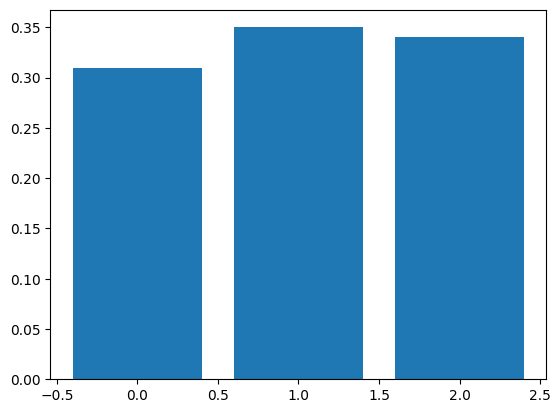

In [10]:
model_1=NBGaussian()
model_1.fit(X_train, y_train)
model_1.plot_pdf()

#### Test wih 1 data record

Label of X_test[10]:  2
Our histogram after update X_test[10]: 


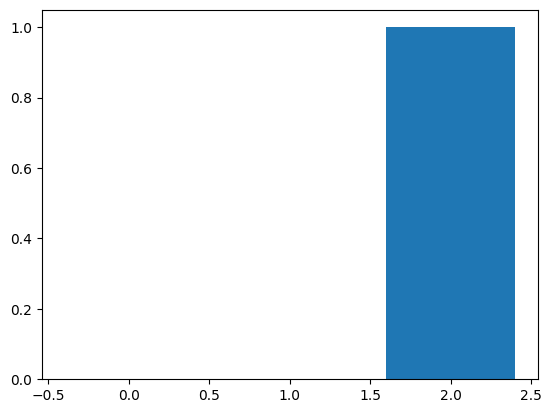

2

In [11]:
#label of y_test[10]
print('Label of X_test[10]: ', y_test[10])
#update model and show histogram with X_test[10]:

print('Our histogram after update X_test[10]: ')
model_1._predict(X_test[10],plot=True)


#### Evaluate your Gaussian Naive Bayes model

In [12]:
pred=model_1.predict(X_test)
print('Accuracy of your Gaussian Naive Bayes model:', accuracy_score(y_test,pred))

Accuracy of your Gaussian Naive Bayes model: 0.96


**TODO**: F1, Recall and Precision report

In [14]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        15
           2       0.94      0.94      0.94        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



The model seems to perform well, with high precision, recall, and F1-score for each class.

The F1-score is 1.00 for class 0, 0.93 for class 1, and 0.94 for class 2.

For class 0, the precision is 1.00, indicating that all instances predicted as class 0 are indeed class 0. For class 1, the precision is 0.93, suggesting that 93% of instances predicted as class 1 are actually class 1. For class 2, the precision is 0.94, indicating a similar accuracy in positive predictions for class 2.

For class 0, the recall is 1.00, indicating that the classifier captures all instances of class 0. For class 1, the recall is 0.93, suggesting that 93% of actual class 1 instances are correctly identified. For class 2, the recall is 0.94, indicating a similar ability to capture class 2 instances